In [1]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from pathlib import Path
import os

load_dotenv()

True

In [2]:
DB_PATH = Path("..") / Path(os.getenv("DB_PATH"))

In [3]:
pf = pd.read_csv(DB_PATH)

In [4]:
info = pf.to_numpy()

In [5]:
new_data = []
for entry in info:
    portions = entry[1].split('.')
    if not (len(portions) > 2):
        continue
        # perturbation = 'None' 
        # level = 0
    else:
        perturbation = portions[1]
        if "Noise" in perturbation:
            level = int(perturbation[len('Noise')])
            perturbation = "Noise" 
        elif "Saturate" in perturbation:
            level = int(perturbation[len('Saturate')])
            perturbation = "Saturate" 
        elif "Adversarial" in perturbation:
            level = int(perturbation[len('Adversarial')])
            perturbation = "Adversarial" 
    if not level > 5:     # the database shouldn't have any more than level 5s, but it does from a few experiments... we just filter it out here
        new_data.append( (entry[0], entry[2], perturbation, level, bool(entry[4])) )
    print(f'{entry} perturbation: {perturbation} (level {level})')

['gemini' 'ExxonMobil.Noise2.png' 'ExxonMobil' 'ExxonMobil' True] perturbation: Noise (level 2)
['gemini' 'ExxonMobil.Noise3.png' 'ExxonMobil' 'ExxonMobil' True] perturbation: Noise (level 3)
['gemini' 'ExxonMobil.Noise4.png' 'ExxonMobil' 'ExxonMobil' True] perturbation: Noise (level 4)
['gemini' 'Facebook.Noise1.png' 'Facebook' 'Facebook\n' True] perturbation: Noise (level 1)
['gemini' 'Facebook.Noise2.png' 'Facebook' 'Facebook\n' True] perturbation: Noise (level 2)
['gemini' 'Facebook.Noise3.png' 'Facebook' 'Facebook\n' True] perturbation: Noise (level 3)
['gemini' 'Facebook.Noise4.png' 'Facebook' 'Facebook' True] perturbation: Noise (level 4)
['gemini' 'FedEx.Noise1.png' 'FedEx' 'FedEx' True] perturbation: Noise (level 1)
['gemini' 'FedEx.Noise2.png' 'FedEx' 'FedEx' True] perturbation: Noise (level 2)
['gemini' 'FedEx.Noise3.png' 'FedEx' 'FedEx' True] perturbation: Noise (level 3)
['gemini' 'FedEx.Noise4.png' 'FedEx' 'FedEx' True] perturbation: Noise (level 4)
['gemini' 'Google.Nois

In [6]:
new_pf = pd.DataFrame(new_data, columns=('model', 'logo', 'perturbation', 'level', 'correct'))
new_pf.to_csv('../refined_db.csv', index=False)

In [7]:
counts = {'Noise':0, 'Saturate':0, 'Adversarial':0}
noise_levels = np.zeros(5, dtype=int)               # 5 noise levels
saturate_levels = np.zeros(5, dtype=int)            # 5 saturation levels
adversarial_levels = np.zeros(2, dtype=int)         # adversarial_levels

misclassified = {'gpt': np.zeros(3, dtype=int), 'gemini': np.zeros(3, dtype=int), 'llama': np.zeros(3, dtype=int), 'gemma': np.zeros(3, dtype=int)}

# format: ('model', 'logo', 'perturbation', 'level', 'correctness')
for entry in new_data:
    correctness = entry[4]
    perturbation = entry[2]

    counts[perturbation] += 1

    if correctness:
        continue
    
    level = entry[3] - 1
    model = entry[0]

    if perturbation == 'Noise':
        noise_levels[level] += 1
        misclassified[model][0] += 1
    elif perturbation == 'Saturate':
        saturate_levels[level] += 1
        misclassified[model][1] += 1
    elif perturbation == 'Adversarial':
        adversarial_levels[level] += 1
        misclassified[model][2] += 1
    else:
        raise Exception("unrecognized perturbation")    

print(f'incorrect count: {np.sum(noise_levels) + np.sum(saturate_levels) + np.sum(adversarial_levels)}')
print(f'counts: {counts}')

incorrect count: 95
counts: {'Noise': 662, 'Saturate': 370, 'Adversarial': 74}


In [8]:
import matplotlib.pyplot as plt

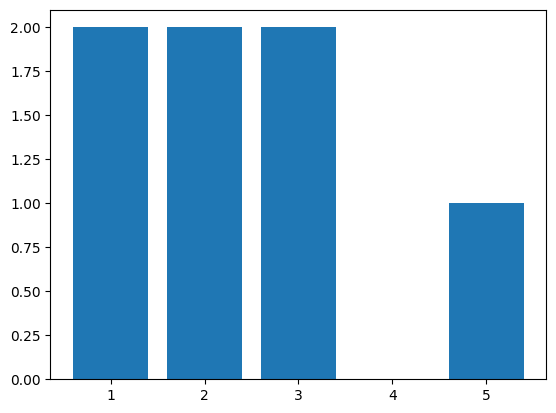

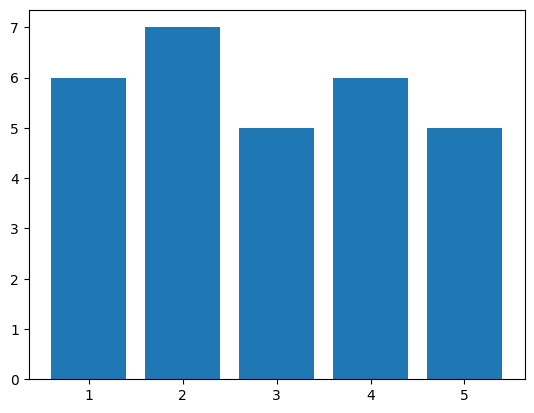

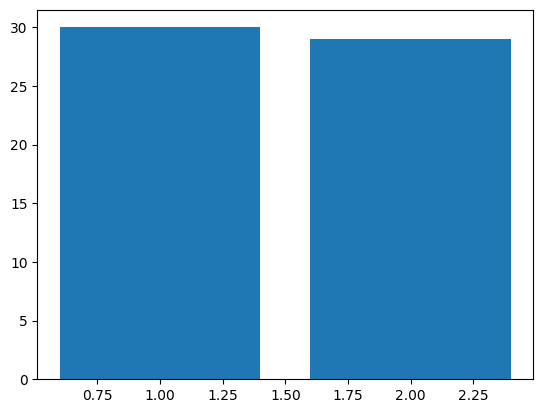

In [9]:
plt.bar(list(range(1, 6)), noise_levels)
plt.show()

plt.bar(list(range(1, 6)), saturate_levels)
plt.show()

plt.bar(list(range(1, 3)), adversarial_levels)
plt.show()

In [10]:
noise_levels_formatted = [(i + 1, level)for i, level in enumerate(noise_levels)]
print(noise_levels_formatted)
pd.DataFrame(noise_levels_formatted, columns=("noise level", "misclassified")).to_csv("../noise_levels.csv", index=False)

[(1, np.int64(2)), (2, np.int64(2)), (3, np.int64(2)), (4, np.int64(0)), (5, np.int64(1))]


In [11]:
saturate_levels_formatted = [(i + 1, level)for i, level in enumerate(saturate_levels)]
print(saturate_levels_formatted)
pd.DataFrame(saturate_levels_formatted, columns=("saturation level", "misclassified")).to_csv("../saturate_levels.csv", index=False)

[(1, np.int64(6)), (2, np.int64(7)), (3, np.int64(5)), (4, np.int64(6)), (5, np.int64(5))]


In [12]:
adversarial_levels_formatted = [(i, level) for i, level in zip([0.05, 0.1], adversarial_levels)]
print(adversarial_levels_formatted)
pd.DataFrame(adversarial_levels_formatted, columns=("epsilon", "misclassified")).to_csv("../adversarial_levels.csv", index=False)

[(0.05, np.int64(30)), (0.1, np.int64(29))]


In [13]:
misclassified_formatted = [(model, data[0], data[1], data[2]) for model, data in list(zip(misclassified.keys(), misclassified.values()))]
print(misclassified_formatted)
pd.DataFrame(misclassified_formatted, columns=["model", "random noise", "saturation", "adversarial"]).to_csv("../permodel.csv", index=False)

[('gpt', np.int64(0), np.int64(0), np.int64(0)), ('gemini', np.int64(0), np.int64(4), np.int64(0)), ('llama', np.int64(2), np.int64(0), np.int64(0)), ('gemma', np.int64(5), np.int64(25), np.int64(59))]
